http://cocodataset.org/#download - Датасет, который использовался для тренировки.

В данном ноутбуке описана сеть U-Net, которая состоит из нескольких слоев: 
    * Convoltion
    * Maxpooling
    * Dropout
    * Transposed Convolution
    
__Convolution__ --- обычная свертка, их используется несколько штук. Пусть $K$ --- матрица $(2l+1)\times{}(2l+1)$, ядро свертки. Тогда образ свертки $B$ задается следующим образом (есть различные варианты обработки изображения по краям):

$$B = K * A $$
$$b_{m,n} = \sum_{-l\leq{}i,j\leq{}l}{a_{m+i,n+j}k_{m+i,n+j}} $$

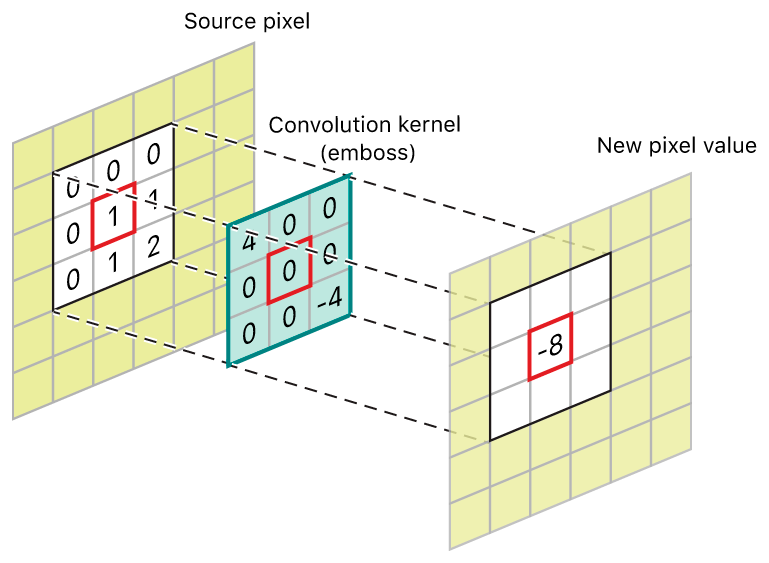


__Maxpooling__ --- слой, где по изображению проходит сканирующее окно, и для каждого своего положения оно отбирает максимальное значение из окна. (Как и в свертке, есть различные способы обработки изображения по краям)

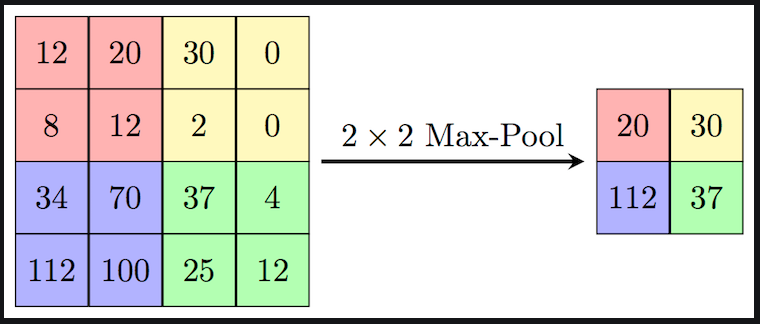

**Dropout** --- этап, когда часть нейронов "выбрасывается" из модели. То есть они больше не учевствуют в тренировке и предсказывании. В первую очередь это делается чтобы предотвратить переобучение на тренировочных данных. 
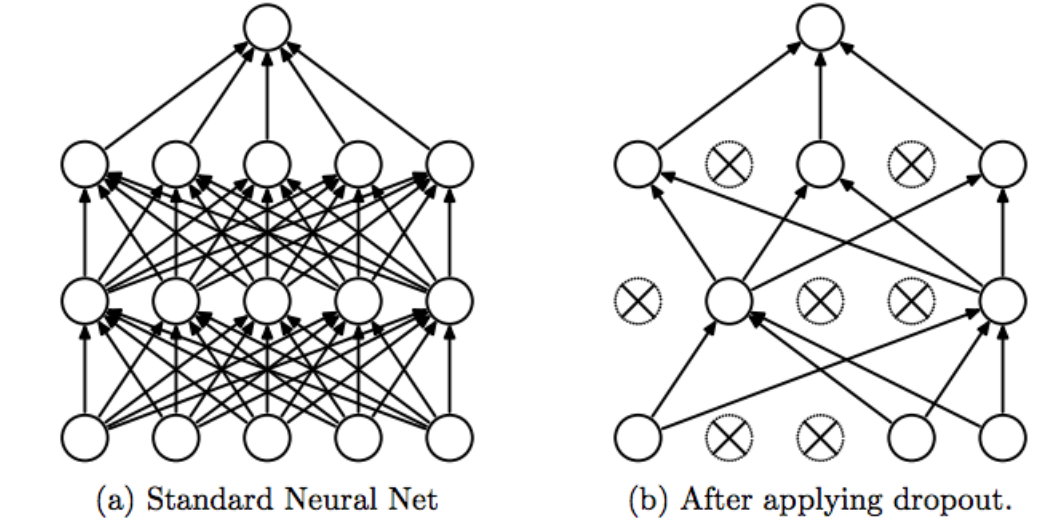

**Transposed convolution** ---   способ получить обратно изображение изначального разрешения после его сжатия. Выучив во время тренировки оптимальное ядро, можно эффективно увеличить размер изображения, вплоть до изначального. 
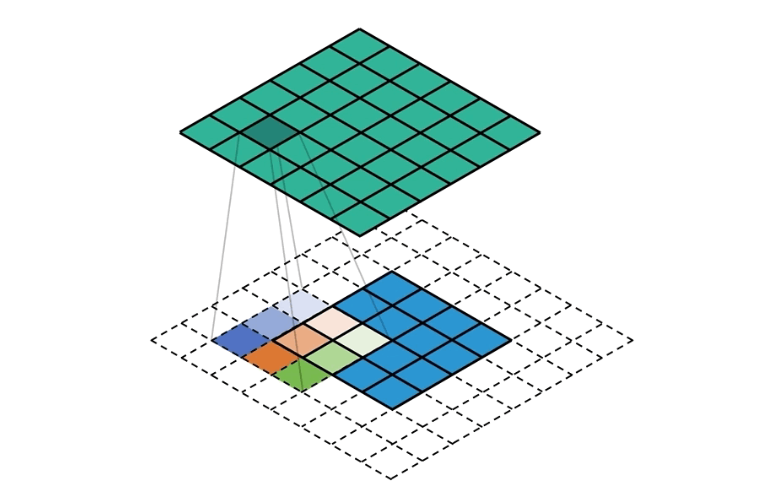

Сама архитектура сети выглядит примерно так:

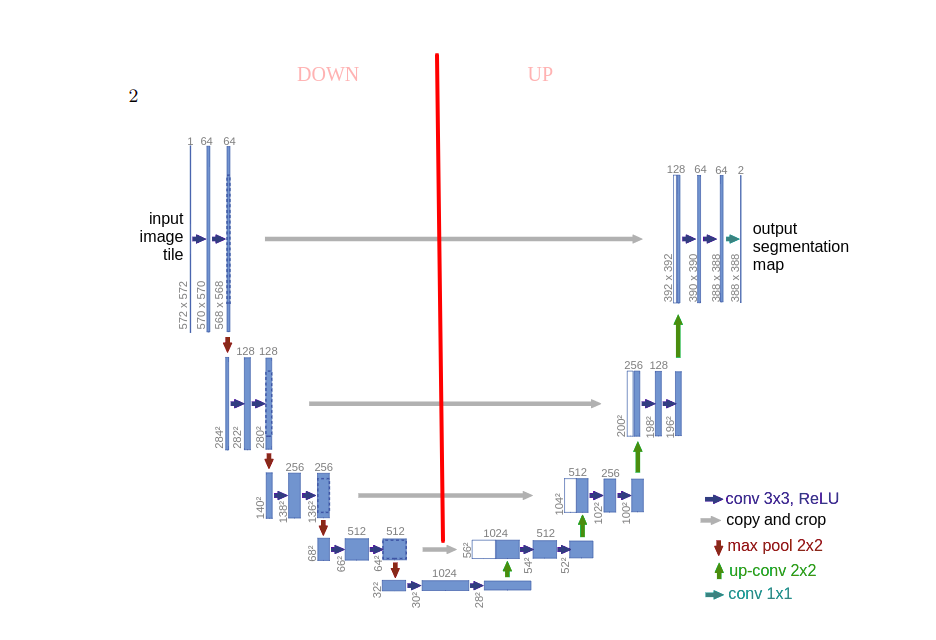

По мере прохождения по сети, изображение уменьшается в размере, но увеличивается количество слоев фич, которые используются. Потом, когда в самом низу остается только один пиксель, с помощью upsampling-а изображение вновь восстанавливается до изначального изображения.

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from cv2 import filter2D

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
ids = next(os.walk("data/images"))[2] # list of names all images in the given path
ids_m = next(os.walk("data/masks"))[2] # list of names all images in the given path

print("No. of images = ", len(ids))

No. of images =  5100


In [4]:
im_width = 128
im_height = 128

In [5]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [7]:
kernel_size = 3
kernel = -1 * np.ones((kernel_size, kernel_size))
kernel[kernel_size // 2 + 1, kernel_size// 2 + 1] = kernel_size ** 2 - 1

for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    img = load_img("data/images/"+id_, color_mode = "grayscale")
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("data/masks/"+ id_[:-4] + '.png', color_mode = "grayscale"))
    mask = filter2D(mask[...,0] , -1, kernel)
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    mask[mask!=0] = 1
    X[n] = x_img/255.0
    y[n] = mask/255.0
    
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [8]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [17]:
# def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
#     # contracting path
#     c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
#     p1 = MaxPooling2D((2, 2)) (c1)
#     p1 = Dropout(dropout*0.5)(p1)

#     c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
#     p2 = MaxPooling2D((2, 2)) (c2)
#     p2 = Dropout(dropout)(p2)

#     c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
#     p3 = MaxPooling2D((2, 2)) (c3)
#     p3 = Dropout(dropout)(p3)

#     c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
#     p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
#     p4 = Dropout(dropout)(p4)
    
#     c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
#     # expansive path
#     u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
#     u6 = concatenate([u6, c4])
#     u6 = Dropout(dropout)(u6)
#     c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

#     u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
#     u7 = concatenate([u7, c3])
#     u7 = Dropout(dropout)(u7)
#     c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

#     u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
#     u8 = concatenate([u8, c2])
#     u8 = Dropout(dropout)(u8)
#     c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

#     u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
#     u9 = concatenate([u9, c1], axis=3)
#     u9 = Dropout(dropout)(u9)
#     c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
#     outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
#     model = Model(inputs=[input_img], outputs=[outputs])
#     return model


def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)


    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c3)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
from keras.layers import Layer
import keras.backend as K

In [18]:
# def weighted_bce(y_true, y_pred):
#     weights = (y_true * 3.) + 1.
#     bce = K.binary_crossentropy(y_true, y_pred)
#     weighted_bce = K.mean(bce * weights)
#     return weighted_bce

In [25]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.01, batchnorm=True)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer=Adam(), loss=weighted_bce, metrics=["accuracy"])

# model.summary()

In [26]:
callbacks = [
    EarlyStopping(patience=10, verbose=0),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=0),
    ModelCheckpoint('model_weighted_1.h5', verbose=1, save_best_only=True, save_weights_only=False)
]


In [27]:
results = model.fit(X_train, y_train, batch_size=20, epochs=7, callbacks=callbacks,
                    validation_data=(X_valid, y_valid), class_weight = 'auto')


Train on 4590 samples, validate on 510 samples
Epoch 1/7


3680/4590 [=======================>......] - ETA: 13:49 - loss: 0.5850 - accuracy: 0.513 - ETA: 7:50 - loss: 0.5631 - accuracy: 0.563 - ETA: 5:50 - loss: 0.5486 - accuracy: 0.59 - ETA: 4:50 - loss: 0.5365 - accuracy: 0.60 - ETA: 4:16 - loss: 0.5263 - accuracy: 0.61 - ETA: 3:51 - loss: 0.5162 - accuracy: 0.62 - ETA: 3:35 - loss: 0.5062 - accuracy: 0.64 - ETA: 3:22 - loss: 0.4974 - accuracy: 0.64 - ETA: 3:12 - loss: 0.4880 - accuracy: 0.65 - ETA: 3:04 - loss: 0.4804 - accuracy: 0.66 - ETA: 2:57 - loss: 0.4733 - accuracy: 0.66 - ETA: 2:51 - loss: 0.4661 - accuracy: 0.67 - ETA: 2:47 - loss: 0.4587 - accuracy: 0.67 - ETA: 2:42 - loss: 0.4517 - accuracy: 0.68 - ETA: 2:40 - loss: 0.4449 - accuracy: 0.68 - ETA: 2:38 - loss: 0.4384 - accuracy: 0.68 - ETA: 2:35 - loss: 0.4318 - accuracy: 0.69 - ETA: 2:33 - loss: 0.4258 - accuracy: 0.69 - ETA: 2:31 - loss: 0.4200 - accuracy: 0.69 - ETA: 2:29 - loss: 0.4142 - accuracy: 0.70 - ETA: 2:28 - loss: 0.4085 - accuracy: 0.70 - ETA: 2:26 - loss: 0.4032 - a

4590/4590 [==============================] - ETA: 26s - loss: 0.1654 - accuracy: 0.753 - ETA: 25s - loss: 0.1650 - accuracy: 0.753 - ETA: 25s - loss: 0.1645 - accuracy: 0.753 - ETA: 24s - loss: 0.1640 - accuracy: 0.753 - ETA: 23s - loss: 0.1636 - accuracy: 0.753 - ETA: 23s - loss: 0.1631 - accuracy: 0.753 - ETA: 22s - loss: 0.1626 - accuracy: 0.753 - ETA: 22s - loss: 0.1622 - accuracy: 0.753 - ETA: 21s - loss: 0.1617 - accuracy: 0.753 - ETA: 20s - loss: 0.1613 - accuracy: 0.753 - ETA: 20s - loss: 0.1608 - accuracy: 0.753 - ETA: 19s - loss: 0.1604 - accuracy: 0.753 - ETA: 19s - loss: 0.1599 - accuracy: 0.753 - ETA: 18s - loss: 0.1595 - accuracy: 0.753 - ETA: 18s - loss: 0.1590 - accuracy: 0.753 - ETA: 17s - loss: 0.1586 - accuracy: 0.754 - ETA: 16s - loss: 0.1582 - accuracy: 0.754 - ETA: 16s - loss: 0.1577 - accuracy: 0.753 - ETA: 15s - loss: 0.1573 - accuracy: 0.753 - ETA: 15s - loss: 0.1569 - accuracy: 0.753 - ETA: 14s - loss: 0.1564 - accuracy: 0.753 - ETA: 13s - loss: 0.1560 - accur

3720/4590 [=======================>......] - ETA: 1:56 - loss: 0.0593 - accuracy: 0.76 - ETA: 1:59 - loss: 0.0587 - accuracy: 0.77 - ETA: 2:01 - loss: 0.0585 - accuracy: 0.76 - ETA: 2:01 - loss: 0.0583 - accuracy: 0.77 - ETA: 2:01 - loss: 0.0582 - accuracy: 0.76 - ETA: 2:04 - loss: 0.0581 - accuracy: 0.76 - ETA: 2:05 - loss: 0.0580 - accuracy: 0.76 - ETA: 2:05 - loss: 0.0580 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0578 - accuracy: 0.75 - ETA: 2:08 - loss: 0.0576 - accuracy: 0.75 - ETA: 2:08 - loss: 0.0575 - accuracy: 0.76 - ETA: 2:08 - loss: 0.0574 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0572 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0571 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0569 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0568 - accuracy: 0.75 - ETA: 2:05 - loss: 0.0566 - accuracy: 0.75 - ETA: 2:04 - loss: 0.0564 - accuracy: 0.76 - ETA: 2:03 - loss: 0.0563 - accuracy: 0.76 - ETA: 2:02 - loss: 0.0561 - accuracy: 0.76 - ETA: 2:01 - loss: 0.0560 - accuracy: 0.76 - ETA: 2:00 - loss: 0.0558 - accu

4590/4590 [==============================] - ETA: 32s - loss: 0.0399 - accuracy: 0.759 - ETA: 31s - loss: 0.0398 - accuracy: 0.759 - ETA: 30s - loss: 0.0397 - accuracy: 0.760 - ETA: 29s - loss: 0.0397 - accuracy: 0.760 - ETA: 29s - loss: 0.0396 - accuracy: 0.760 - ETA: 28s - loss: 0.0395 - accuracy: 0.760 - ETA: 27s - loss: 0.0394 - accuracy: 0.760 - ETA: 26s - loss: 0.0394 - accuracy: 0.760 - ETA: 26s - loss: 0.0393 - accuracy: 0.760 - ETA: 25s - loss: 0.0393 - accuracy: 0.759 - ETA: 24s - loss: 0.0392 - accuracy: 0.759 - ETA: 23s - loss: 0.0391 - accuracy: 0.759 - ETA: 22s - loss: 0.0391 - accuracy: 0.759 - ETA: 22s - loss: 0.0390 - accuracy: 0.759 - ETA: 21s - loss: 0.0389 - accuracy: 0.759 - ETA: 20s - loss: 0.0389 - accuracy: 0.759 - ETA: 19s - loss: 0.0388 - accuracy: 0.759 - ETA: 19s - loss: 0.0387 - accuracy: 0.759 - ETA: 18s - loss: 0.0387 - accuracy: 0.759 - ETA: 17s - loss: 0.0386 - accuracy: 0.759 - ETA: 16s - loss: 0.0385 - accuracy: 0.759 - ETA: 16s - loss: 0.0385 - accur

3720/4590 [=======================>......] - ETA: 1:59 - loss: 0.0237 - accuracy: 0.75 - ETA: 2:02 - loss: 0.0236 - accuracy: 0.76 - ETA: 2:08 - loss: 0.0236 - accuracy: 0.75 - ETA: 2:08 - loss: 0.0237 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0237 - accuracy: 0.74 - ETA: 2:05 - loss: 0.0237 - accuracy: 0.75 - ETA: 2:04 - loss: 0.0236 - accuracy: 0.75 - ETA: 2:04 - loss: 0.0235 - accuracy: 0.75 - ETA: 2:05 - loss: 0.0235 - accuracy: 0.75 - ETA: 2:05 - loss: 0.0234 - accuracy: 0.75 - ETA: 2:04 - loss: 0.0234 - accuracy: 0.75 - ETA: 2:03 - loss: 0.0234 - accuracy: 0.75 - ETA: 2:02 - loss: 0.0234 - accuracy: 0.75 - ETA: 2:03 - loss: 0.0234 - accuracy: 0.75 - ETA: 2:03 - loss: 0.0234 - accuracy: 0.75 - ETA: 2:03 - loss: 0.0233 - accuracy: 0.75 - ETA: 2:03 - loss: 0.0233 - accuracy: 0.75 - ETA: 2:02 - loss: 0.0233 - accuracy: 0.75 - ETA: 2:02 - loss: 0.0233 - accuracy: 0.75 - ETA: 2:01 - loss: 0.0233 - accuracy: 0.75 - ETA: 2:01 - loss: 0.0232 - accuracy: 0.75 - ETA: 2:00 - loss: 0.0232 - accu

4590/4590 [==============================] - ETA: 24s - loss: 0.0188 - accuracy: 0.759 - ETA: 23s - loss: 0.0188 - accuracy: 0.759 - ETA: 22s - loss: 0.0188 - accuracy: 0.759 - ETA: 22s - loss: 0.0188 - accuracy: 0.759 - ETA: 21s - loss: 0.0187 - accuracy: 0.759 - ETA: 21s - loss: 0.0187 - accuracy: 0.760 - ETA: 20s - loss: 0.0187 - accuracy: 0.759 - ETA: 20s - loss: 0.0187 - accuracy: 0.759 - ETA: 19s - loss: 0.0186 - accuracy: 0.759 - ETA: 18s - loss: 0.0186 - accuracy: 0.759 - ETA: 18s - loss: 0.0186 - accuracy: 0.759 - ETA: 17s - loss: 0.0186 - accuracy: 0.759 - ETA: 17s - loss: 0.0186 - accuracy: 0.759 - ETA: 16s - loss: 0.0186 - accuracy: 0.759 - ETA: 16s - loss: 0.0185 - accuracy: 0.760 - ETA: 15s - loss: 0.0185 - accuracy: 0.759 - ETA: 14s - loss: 0.0185 - accuracy: 0.760 - ETA: 14s - loss: 0.0185 - accuracy: 0.760 - ETA: 13s - loss: 0.0185 - accuracy: 0.759 - ETA: 13s - loss: 0.0184 - accuracy: 0.759 - ETA: 12s - loss: 0.0184 - accuracy: 0.759 - ETA: 12s - loss: 0.0184 - accur

3720/4590 [=======================>......] - ETA: 1:57 - loss: 0.0135 - accuracy: 0.78 - ETA: 2:02 - loss: 0.0136 - accuracy: 0.78 - ETA: 2:03 - loss: 0.0136 - accuracy: 0.77 - ETA: 2:03 - loss: 0.0136 - accuracy: 0.77 - ETA: 2:03 - loss: 0.0137 - accuracy: 0.77 - ETA: 2:03 - loss: 0.0136 - accuracy: 0.77 - ETA: 2:03 - loss: 0.0136 - accuracy: 0.77 - ETA: 2:03 - loss: 0.0136 - accuracy: 0.77 - ETA: 2:03 - loss: 0.0136 - accuracy: 0.77 - ETA: 2:02 - loss: 0.0137 - accuracy: 0.77 - ETA: 2:02 - loss: 0.0137 - accuracy: 0.77 - ETA: 2:01 - loss: 0.0137 - accuracy: 0.77 - ETA: 2:01 - loss: 0.0137 - accuracy: 0.77 - ETA: 2:00 - loss: 0.0137 - accuracy: 0.76 - ETA: 2:00 - loss: 0.0137 - accuracy: 0.76 - ETA: 1:59 - loss: 0.0137 - accuracy: 0.76 - ETA: 1:59 - loss: 0.0137 - accuracy: 0.76 - ETA: 1:58 - loss: 0.0137 - accuracy: 0.76 - ETA: 1:57 - loss: 0.0137 - accuracy: 0.76 - ETA: 1:57 - loss: 0.0137 - accuracy: 0.76 - ETA: 1:56 - loss: 0.0137 - accuracy: 0.76 - ETA: 1:55 - loss: 0.0137 - accu

4590/4590 [==============================] - ETA: 26s - loss: 0.0123 - accuracy: 0.758 - ETA: 25s - loss: 0.0123 - accuracy: 0.759 - ETA: 25s - loss: 0.0123 - accuracy: 0.759 - ETA: 24s - loss: 0.0123 - accuracy: 0.759 - ETA: 23s - loss: 0.0122 - accuracy: 0.758 - ETA: 23s - loss: 0.0122 - accuracy: 0.759 - ETA: 22s - loss: 0.0122 - accuracy: 0.759 - ETA: 21s - loss: 0.0122 - accuracy: 0.759 - ETA: 21s - loss: 0.0122 - accuracy: 0.759 - ETA: 20s - loss: 0.0122 - accuracy: 0.759 - ETA: 20s - loss: 0.0122 - accuracy: 0.759 - ETA: 19s - loss: 0.0122 - accuracy: 0.758 - ETA: 18s - loss: 0.0122 - accuracy: 0.758 - ETA: 18s - loss: 0.0122 - accuracy: 0.758 - ETA: 17s - loss: 0.0122 - accuracy: 0.759 - ETA: 16s - loss: 0.0122 - accuracy: 0.759 - ETA: 16s - loss: 0.0122 - accuracy: 0.759 - ETA: 15s - loss: 0.0122 - accuracy: 0.758 - ETA: 15s - loss: 0.0121 - accuracy: 0.758 - ETA: 14s - loss: 0.0121 - accuracy: 0.758 - ETA: 13s - loss: 0.0121 - accuracy: 0.759 - ETA: 13s - loss: 0.0121 - accur

3720/4590 [=======================>......] - ETA: 1:57 - loss: 0.0103 - accuracy: 0.76 - ETA: 2:03 - loss: 0.0109 - accuracy: 0.73 - ETA: 2:05 - loss: 0.0109 - accuracy: 0.73 - ETA: 2:05 - loss: 0.0107 - accuracy: 0.74 - ETA: 2:06 - loss: 0.0106 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0105 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0106 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0105 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0105 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0105 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0105 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0104 - accuracy: 0.75 - ETA: 2:05 - loss: 0.0104 - accuracy: 0.76 - ETA: 2:04 - loss: 0.0104 - accuracy: 0.76 - ETA: 2:04 - loss: 0.0103 - accuracy: 0.76 - ETA: 2:03 - loss: 0.0102 - accuracy: 0.76 - ETA: 2:02 - loss: 0.0102 - accuracy: 0.76 - ETA: 2:02 - loss: 0.0102 - accuracy: 0.76 - ETA: 2:01 - loss: 0.0101 - accuracy: 0.77 - ETA: 2:01 - loss: 0.0101 - accuracy: 0.77 - ETA: 2:00 - loss: 0.0102 - accuracy: 0.76 - ETA: 2:00 - loss: 0.0101 - accu

4590/4590 [==============================] - ETA: 25s - loss: 0.0097 - accuracy: 0.759 - ETA: 25s - loss: 0.0097 - accuracy: 0.759 - ETA: 24s - loss: 0.0097 - accuracy: 0.759 - ETA: 24s - loss: 0.0097 - accuracy: 0.759 - ETA: 23s - loss: 0.0097 - accuracy: 0.759 - ETA: 22s - loss: 0.0097 - accuracy: 0.759 - ETA: 22s - loss: 0.0097 - accuracy: 0.759 - ETA: 21s - loss: 0.0097 - accuracy: 0.759 - ETA: 21s - loss: 0.0097 - accuracy: 0.759 - ETA: 20s - loss: 0.0097 - accuracy: 0.759 - ETA: 19s - loss: 0.0097 - accuracy: 0.759 - ETA: 19s - loss: 0.0097 - accuracy: 0.759 - ETA: 18s - loss: 0.0097 - accuracy: 0.759 - ETA: 17s - loss: 0.0097 - accuracy: 0.759 - ETA: 17s - loss: 0.0097 - accuracy: 0.758 - ETA: 16s - loss: 0.0097 - accuracy: 0.758 - ETA: 16s - loss: 0.0097 - accuracy: 0.758 - ETA: 15s - loss: 0.0097 - accuracy: 0.758 - ETA: 14s - loss: 0.0097 - accuracy: 0.758 - ETA: 14s - loss: 0.0097 - accuracy: 0.759 - ETA: 13s - loss: 0.0097 - accuracy: 0.758 - ETA: 13s - loss: 0.0097 - accur

3720/4590 [=======================>......] - ETA: 1:58 - loss: 0.0084 - accuracy: 0.78 - ETA: 2:03 - loss: 0.0089 - accuracy: 0.76 - ETA: 2:05 - loss: 0.0086 - accuracy: 0.77 - ETA: 2:06 - loss: 0.0087 - accuracy: 0.77 - ETA: 2:06 - loss: 0.0088 - accuracy: 0.76 - ETA: 2:06 - loss: 0.0088 - accuracy: 0.76 - ETA: 2:06 - loss: 0.0089 - accuracy: 0.76 - ETA: 2:06 - loss: 0.0090 - accuracy: 0.75 - ETA: 2:05 - loss: 0.0089 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0089 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0090 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0091 - accuracy: 0.75 - ETA: 2:08 - loss: 0.0090 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0091 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0091 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0090 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0090 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0090 - accuracy: 0.75 - ETA: 2:05 - loss: 0.0090 - accuracy: 0.75 - ETA: 2:04 - loss: 0.0090 - accuracy: 0.75 - ETA: 2:03 - loss: 0.0090 - accuracy: 0.75 - ETA: 2:03 - loss: 0.0090 - accu

4590/4590 [==============================] - ETA: 24s - loss: 0.0086 - accuracy: 0.758 - ETA: 23s - loss: 0.0086 - accuracy: 0.758 - ETA: 23s - loss: 0.0086 - accuracy: 0.758 - ETA: 22s - loss: 0.0086 - accuracy: 0.758 - ETA: 21s - loss: 0.0086 - accuracy: 0.758 - ETA: 21s - loss: 0.0086 - accuracy: 0.758 - ETA: 20s - loss: 0.0086 - accuracy: 0.758 - ETA: 20s - loss: 0.0086 - accuracy: 0.758 - ETA: 19s - loss: 0.0086 - accuracy: 0.758 - ETA: 19s - loss: 0.0086 - accuracy: 0.758 - ETA: 18s - loss: 0.0086 - accuracy: 0.758 - ETA: 17s - loss: 0.0086 - accuracy: 0.758 - ETA: 17s - loss: 0.0086 - accuracy: 0.758 - ETA: 16s - loss: 0.0086 - accuracy: 0.758 - ETA: 16s - loss: 0.0086 - accuracy: 0.759 - ETA: 15s - loss: 0.0086 - accuracy: 0.758 - ETA: 15s - loss: 0.0086 - accuracy: 0.759 - ETA: 14s - loss: 0.0086 - accuracy: 0.759 - ETA: 13s - loss: 0.0086 - accuracy: 0.759 - ETA: 13s - loss: 0.0086 - accuracy: 0.759 - ETA: 12s - loss: 0.0086 - accuracy: 0.759 - ETA: 12s - loss: 0.0086 - accur

3720/4590 [=======================>......] - ETA: 2:01 - loss: 0.0084 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0084 - accuracy: 0.75 - ETA: 2:09 - loss: 0.0083 - accuracy: 0.75 - ETA: 2:09 - loss: 0.0082 - accuracy: 0.76 - ETA: 2:08 - loss: 0.0083 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0082 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0083 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0082 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0082 - accuracy: 0.75 - ETA: 2:08 - loss: 0.0082 - accuracy: 0.75 - ETA: 2:08 - loss: 0.0081 - accuracy: 0.76 - ETA: 2:07 - loss: 0.0082 - accuracy: 0.75 - ETA: 2:07 - loss: 0.0082 - accuracy: 0.76 - ETA: 2:07 - loss: 0.0082 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0082 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0082 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0083 - accuracy: 0.75 - ETA: 2:06 - loss: 0.0083 - accuracy: 0.75 - ETA: 2:05 - loss: 0.0083 - accuracy: 0.75 - ETA: 2:04 - loss: 0.0083 - accuracy: 0.75 - ETA: 2:04 - loss: 0.0083 - accuracy: 0.75 - ETA: 2:03 - loss: 0.0083 - accu

4590/4590 [==============================] - ETA: 24s - loss: 0.0080 - accuracy: 0.758 - ETA: 23s - loss: 0.0080 - accuracy: 0.758 - ETA: 23s - loss: 0.0080 - accuracy: 0.758 - ETA: 22s - loss: 0.0080 - accuracy: 0.758 - ETA: 22s - loss: 0.0080 - accuracy: 0.758 - ETA: 21s - loss: 0.0080 - accuracy: 0.758 - ETA: 21s - loss: 0.0080 - accuracy: 0.759 - ETA: 20s - loss: 0.0080 - accuracy: 0.759 - ETA: 19s - loss: 0.0080 - accuracy: 0.758 - ETA: 19s - loss: 0.0080 - accuracy: 0.759 - ETA: 18s - loss: 0.0080 - accuracy: 0.759 - ETA: 18s - loss: 0.0080 - accuracy: 0.759 - ETA: 17s - loss: 0.0080 - accuracy: 0.759 - ETA: 17s - loss: 0.0080 - accuracy: 0.759 - ETA: 16s - loss: 0.0080 - accuracy: 0.759 - ETA: 15s - loss: 0.0080 - accuracy: 0.759 - ETA: 15s - loss: 0.0080 - accuracy: 0.759 - ETA: 14s - loss: 0.0080 - accuracy: 0.759 - ETA: 14s - loss: 0.0080 - accuracy: 0.758 - ETA: 13s - loss: 0.0080 - accuracy: 0.758 - ETA: 12s - loss: 0.0080 - accuracy: 0.758 - ETA: 12s - loss: 0.0080 - accur

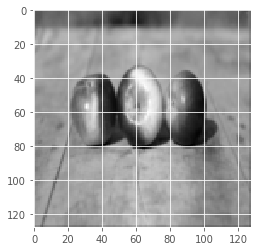

In [36]:
img = img_to_array(load_img("samples/apples.jpg", color_mode = "grayscale"))
img = resize(img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
plt.imshow(img[..., 0], cmap='gray')

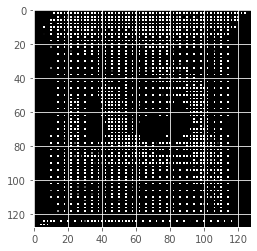

In [38]:
plt.imshow(model.predict(img[np.newaxis, ...])[0, ..., 0] * 256, cmap='gray')